# Amazon Food Review Sentiment Analysis and Predicticon

By <a href="http://dacatay.com/about/">Daniel Kerim Acatay</a>

## Preamble & Libraries

In [154]:
#%load_ext autoreload
#%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# basic functionalities
import re
import os
import sys
import datetime
import itertools
import math 


# metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# text processing
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


# data handling, transforamtion and manipulation
import sqlite3
import pandas as pd
import pandas_datareader.data as web
import numpy as np
# prevent crazy long pandas prints
pd.options.display.max_columns = 16
pd.options.display.max_rows = 16
pd.set_option('display.float_format', lambda x: '%.5f' % x)
#np.set_printoptions(precision=5, suppress=True)


# remove warnings
import warnings
warnings.filterwarnings('ignore')


# plotting and plot styling
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
#sns.set_style("whitegrid", {'axes.grid' : False})
#set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 10)
mpl.rcParams['figure.subplot.bottom']=.1 
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"


# IPython
from IPython.core.display import display, HTML

# Introduction

The purpose of this notebook is to perform sentiment analysis on the Amazon Fine Food Reis to make up a prediction model where we will be able to predict whether a recommendation is positive or negative. In this analysis, we will not focus on the Score, but only the positive/negative sentiment of the recommendation.

In the end, we hope to find a "best" model for predicting the recommendation's sentiment.

A basic workflow example on how to work with text data by SciKit Learn is provided <a href="http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html">here</a>


# Data Handling

## Importing Data

In order to load the data, we will use the SQLITE dataset where we will only fetch the Score and the recommendation summary.

The data underlying this notebook can be downloaded from the original <a href="">Kaggle challenge</a>.

Since we want to distinguish between recommendations with either positive or negative connotation, all neutral recommendation with a score of 3 will be disregarded. If the score is above 3, then the recommendation wile be set to "postive". Otherwise, it will be set to "negative".

The data is split into an training set and a test set with a test set ratio of 0.2

In [80]:
# check if data is present
import os
    
assert os.path.exists('./data/amazon-fine-food-reviews/database.sqlite') == True

In [81]:
import sqlite3

# establish connection to sqlite database
conn = sqlite3.connect('./data/amazon-fine-food-reviews/database.sqlite')

We are following the assumption that a rating of 3 is neutral, which means that there is neither a positive or negative connotation to the review. This means that these recommandations hold no practical value to us and are thus excluded from the data set.

In [51]:
# write query
sqlq = """
SELECT 
  Score, 
  Summary,
  HelpfulnessNumerator AS VotesHelpful,
  HelpfulnessDenominator AS VotesTotal,
  Text
FROM Reviews
WHERE Score != 3
"""

In [52]:
# execute an sql query on a connected database
reviews = pd.read_sql_query(sqlq, conn)

In [53]:
reviews.head()

,Score,Summary,VotesHelpful,VotesTotal,Text
0,5,Good Quality Dog Food,1,1,I have bought several of the Vitality canned d...
1,1,Not as Advertised,0,0,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",1,1,This is a confection that has been around a fe...
3,2,Cough Medicine,3,3,If you are looking for the secret ingredient i...
4,5,Great taffy,0,0,Great taffy at a great price. There was a wid...


# Preprocessing Data

To format our data and build the Term-doc incidence matrix, many operations will be performed on the data :

In [64]:
# add Sentiment column
reviews['Sentiment'] = reviews['Score'].apply(lambda score: 'positive' if score > 3 else 'negative')

# add usefulness column
reviews['Usefulness'] = (reviews['VotesHelpful'] / reviews['VotesTotal']).apply(lambda ratio: 'useful' if ratio > 0.8 else 'useless')

In [65]:
reviews.head()

,Score,Summary,VotesHelpful,VotesTotal,Text,Sentiment,Usefulness
0,5,Good Quality Dog Food,1,1,I have bought several of the Vitality canned d...,positive,useful
1,1,Not as Advertised,0,0,Product arrived labeled as Jumbo Salted Peanut...,negative,useless
2,4,"""Delight"" says it all",1,1,This is a confection that has been around a fe...,positive,useful
3,2,Cough Medicine,3,3,If you are looking for the secret ingredient i...,negative,useful
4,5,Great taffy,0,0,Great taffy at a great price. There was a wid...,positive,useless


In order to clean the data we apply minor preprocessing as we wish to lose as less information as possible. The <code>preprocess_data</code> function is applied to every data row. In a first step the text data is decapitalized. Then all punctuation is removed using the regex <code>[^a-z]+</code>.

In [66]:
# example regex use to filter a sentence
re.compile('[^a-z]+').sub(' ', 'Hello! World!!#####').strip()

'ello orld'

In [67]:
import re

def preprocess_data(text):
    regex = re.compile('[^a-z]+')
    text = text.lower()
    text = regex.sub(' ', text).strip()
    return text

In this snippet we create a regex that includes al lower case ASCII characters. Then we decapitalize the text string. Then we apply the regex as a filter to the data string and strip the start and end of the text string from blanks.

In [82]:
# apply the data preprocessing to every data row for the summary field
reviews["Summary_Clean"] = reviews["Summary"].apply(preprocess_data)

In [83]:
reviews.head(10)

,Score,Summary,VotesHelpful,VotesTotal,Text,Sentiment,Usefulness,Summary_Clean
0,5,Good Quality Dog Food,1,1,I have bought several of the Vitality canned d...,positive,useful,good quality dog food
1,1,Not as Advertised,0,0,Product arrived labeled as Jumbo Salted Peanut...,negative,useless,not as advertised
2,4,"""Delight"" says it all",1,1,This is a confection that has been around a fe...,positive,useful,delight says it all
3,2,Cough Medicine,3,3,If you are looking for the secret ingredient i...,negative,useful,cough medicine
4,5,Great taffy,0,0,Great taffy at a great price. There was a wid...,positive,useless,great taffy
5,4,Nice Taffy,0,0,I got a wild hair for taffy and ordered this f...,positive,useless,nice taffy
6,5,Great! Just as good as the expensive brands!,0,0,This saltwater taffy had great flavors and was...,positive,useless,great just as good as the expensive brands
7,5,"Wonderful, tasty taffy",0,0,This taffy is so good. It is very soft and ch...,positive,useless,wonderful tasty taffy
8,5,Yay Barley,1,1,Right now I'm mostly just sprouting this so my...,positive,useful,yay barley
9,5,Healthy Dog Food,0,0,This is a very healthy dog food. Good for thei...,positive,useless,healthy dog food


# Exploratory Data Analysis

## Tag Cloud

A **tag cloud** (**word cloud**, or **weighted list** in visual design) is a visual representation of text data, which we will use to visualize the most common word tokens

There exist different libraries with different lists of stopwords.

In [161]:
from wordcloud import WordCloud

def plot_wordcloud(data, stopwords, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(' '.join(data))
    
    fig = plt.figure()
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=40)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.tight_layout()
    plt.show()

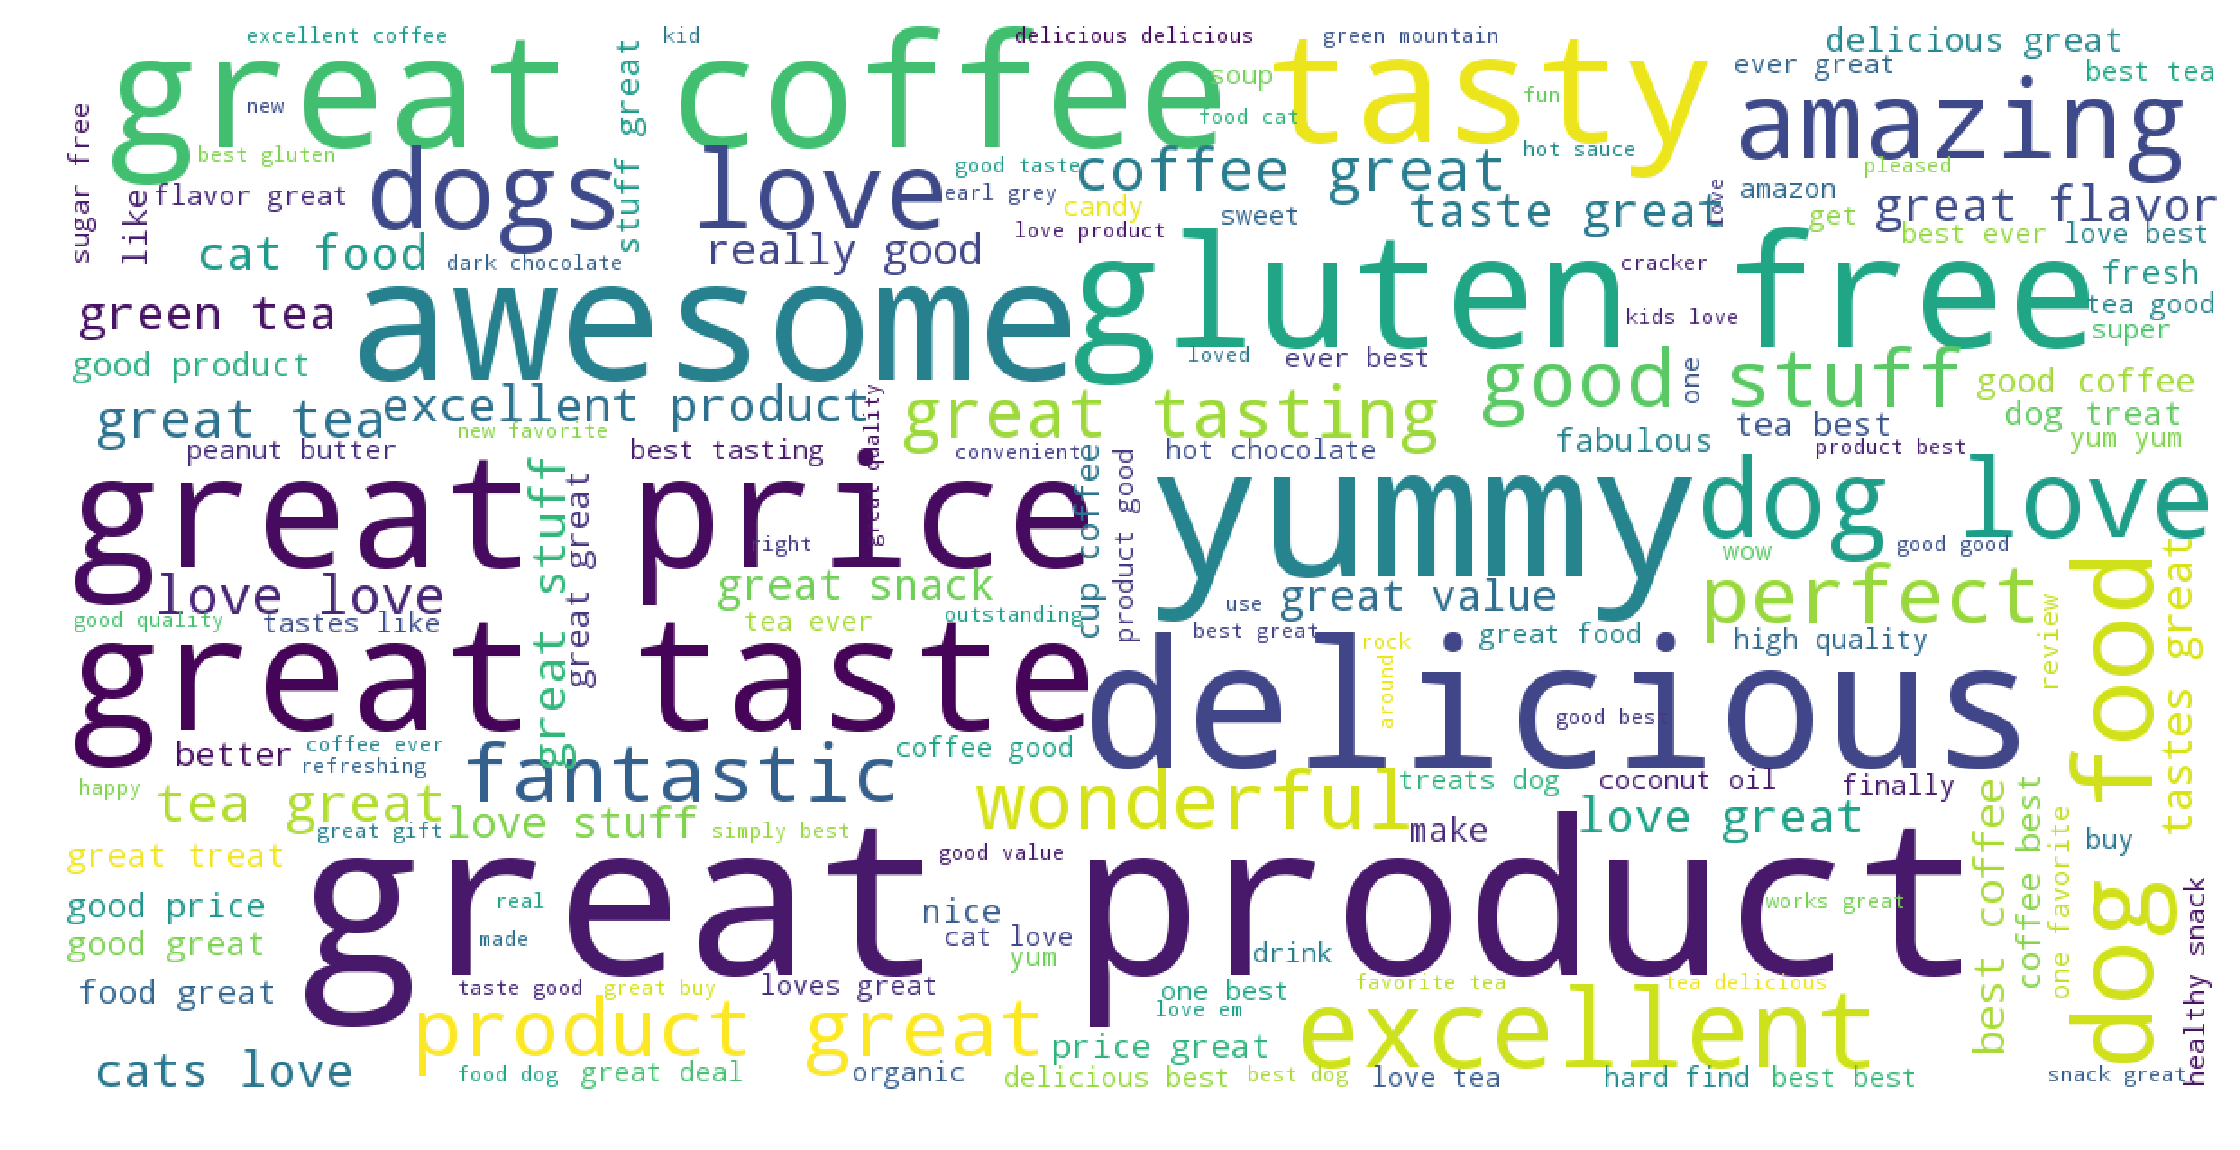

In [164]:
from nltk.corpus import stopwords as sw
stopwords = sw.words('english')

plot_wordcloud(reviews[reviews.Score == 5]["Summary_Clean"], stopwords)

## Train and Test Splitting

In [183]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(reviews, test_size=0.2)

In [184]:
print("{} items in training data, {} in test data".format(len(train), len(test)))

420651 items in training data, 105163 in test data


## Feature Extraction from Text Data

SciKit provides us with a choice of information extraction features for text data. For this analysis we are using the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html"><code>CountVectorizer</code></a> class which converts a collection of text documents to a matrix of token counts

Text preprocessing, tokenizing and filtering of stopwords are included in a high level component that is able to build a dictionary of features and transform documents to feature vectors

In [185]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# No stopwords are included here
# including stopwords reduces accuracy later down the road
# instantiate count verctorizer
count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 4))

# create count matrix for texts in train and test data
X_train_counts = count_vect.fit_transform(train["Summary_Clean"])
X_test_counts = count_vect.transform(test["Summary_Clean"])

Longer documents will have higher average count values than shorter documents, even though they might talk about the same topics.

The index value of a word in the vocabulary is linked to its frequency in the whole training corpus. To avoid these potential discrepancies it suffices to divide the number of occurrences of each word in a document by the total number of words in the document: these new features are called tf for Term Frequencies.

Another refinement on top of tf is to downscale weights for words that occur in many documents in the corpus and are therefore less informative than those that occur only in a smaller portion of the corpus.
This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.

In [186]:
from sklearn.feature_extraction.text import TfidfTransformer

# instantiate TfidfTransformer
tfidf_transformer = TfidfTransformer()

# fit estimator and apply transform according to previous count
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [187]:
# prepare output variable
y_train = train["Sentiment"]
y_test = test["Sentiment"]

## Model Training and Prediction

In [188]:
# dictionary to comapre prediction methods
pred = dict()

In [189]:
# importing machine learning algorithms
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import linear_model

In [190]:
mdl = MultinomialNB().fit(X_train_tfidf, y_train)
pred['Multinomial'] = mdl.predict(X_test_tfidf)

In [191]:
mdl = BernoulliNB().fit(X_train_tfidf, y_train)
pred['Bernoulli'] = mdl.predict(X_test_tfidf)

In [192]:
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(X_train_tfidf, y_train)
pred['Logistic'] = logreg.predict(X_test_tfidf)

## Performance measuring

In [196]:
# encoding for performance measure
encode = lambda x: 0 if x == 'negative' else 1

In [197]:
vfunc = np.vectorize(encode)

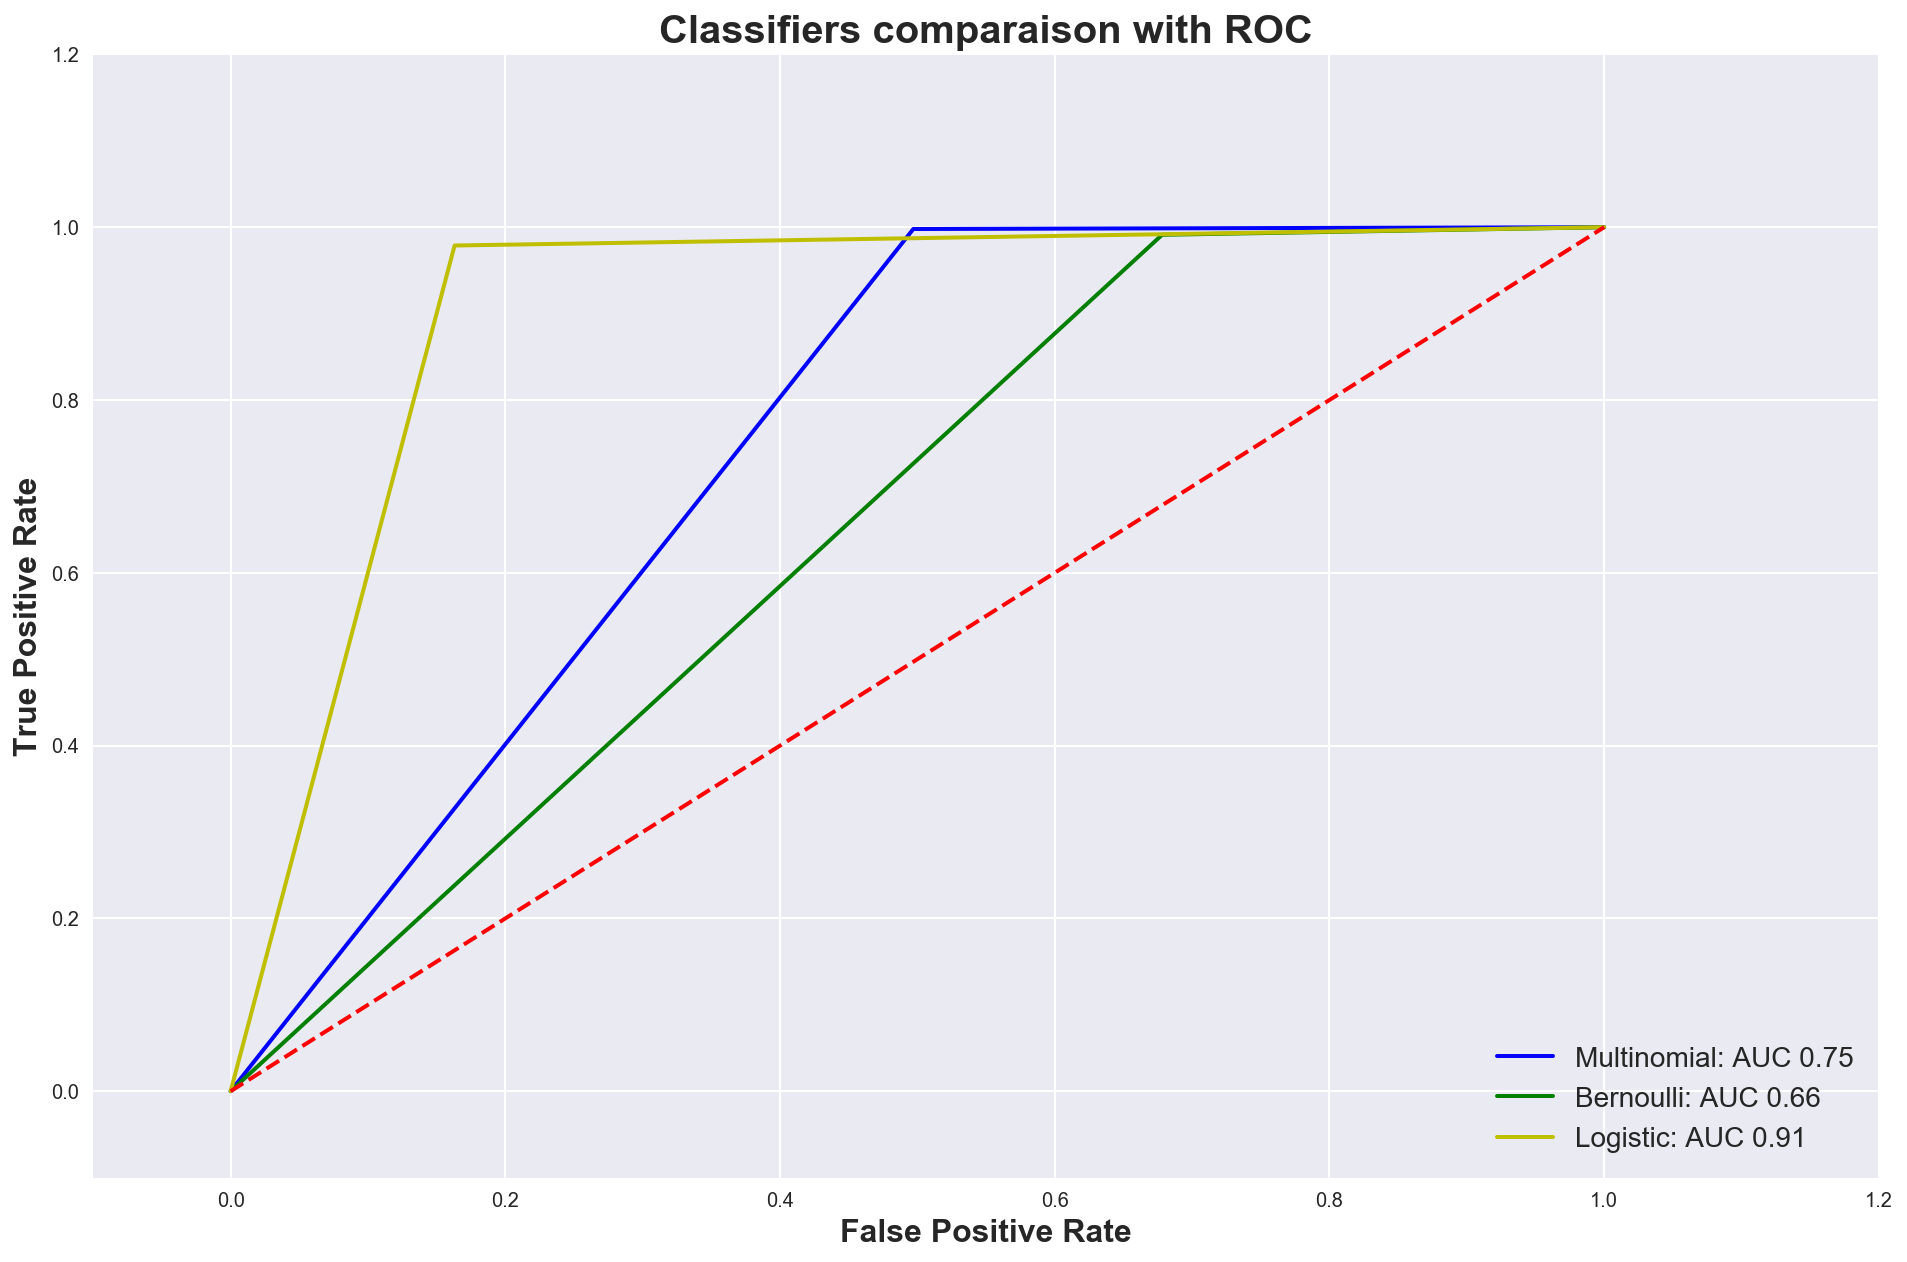

In [198]:
cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for mdl, p in pred.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(encode), vfunc(p))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (mdl,roc_auc))
    cmp += 1

# plot the above
plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [44]:
print(metrics.classification_report(y_test, pred['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.89      0.84      0.86     16515
   negative       0.97      0.98      0.98     88648

avg / total       0.96      0.96      0.96    105163



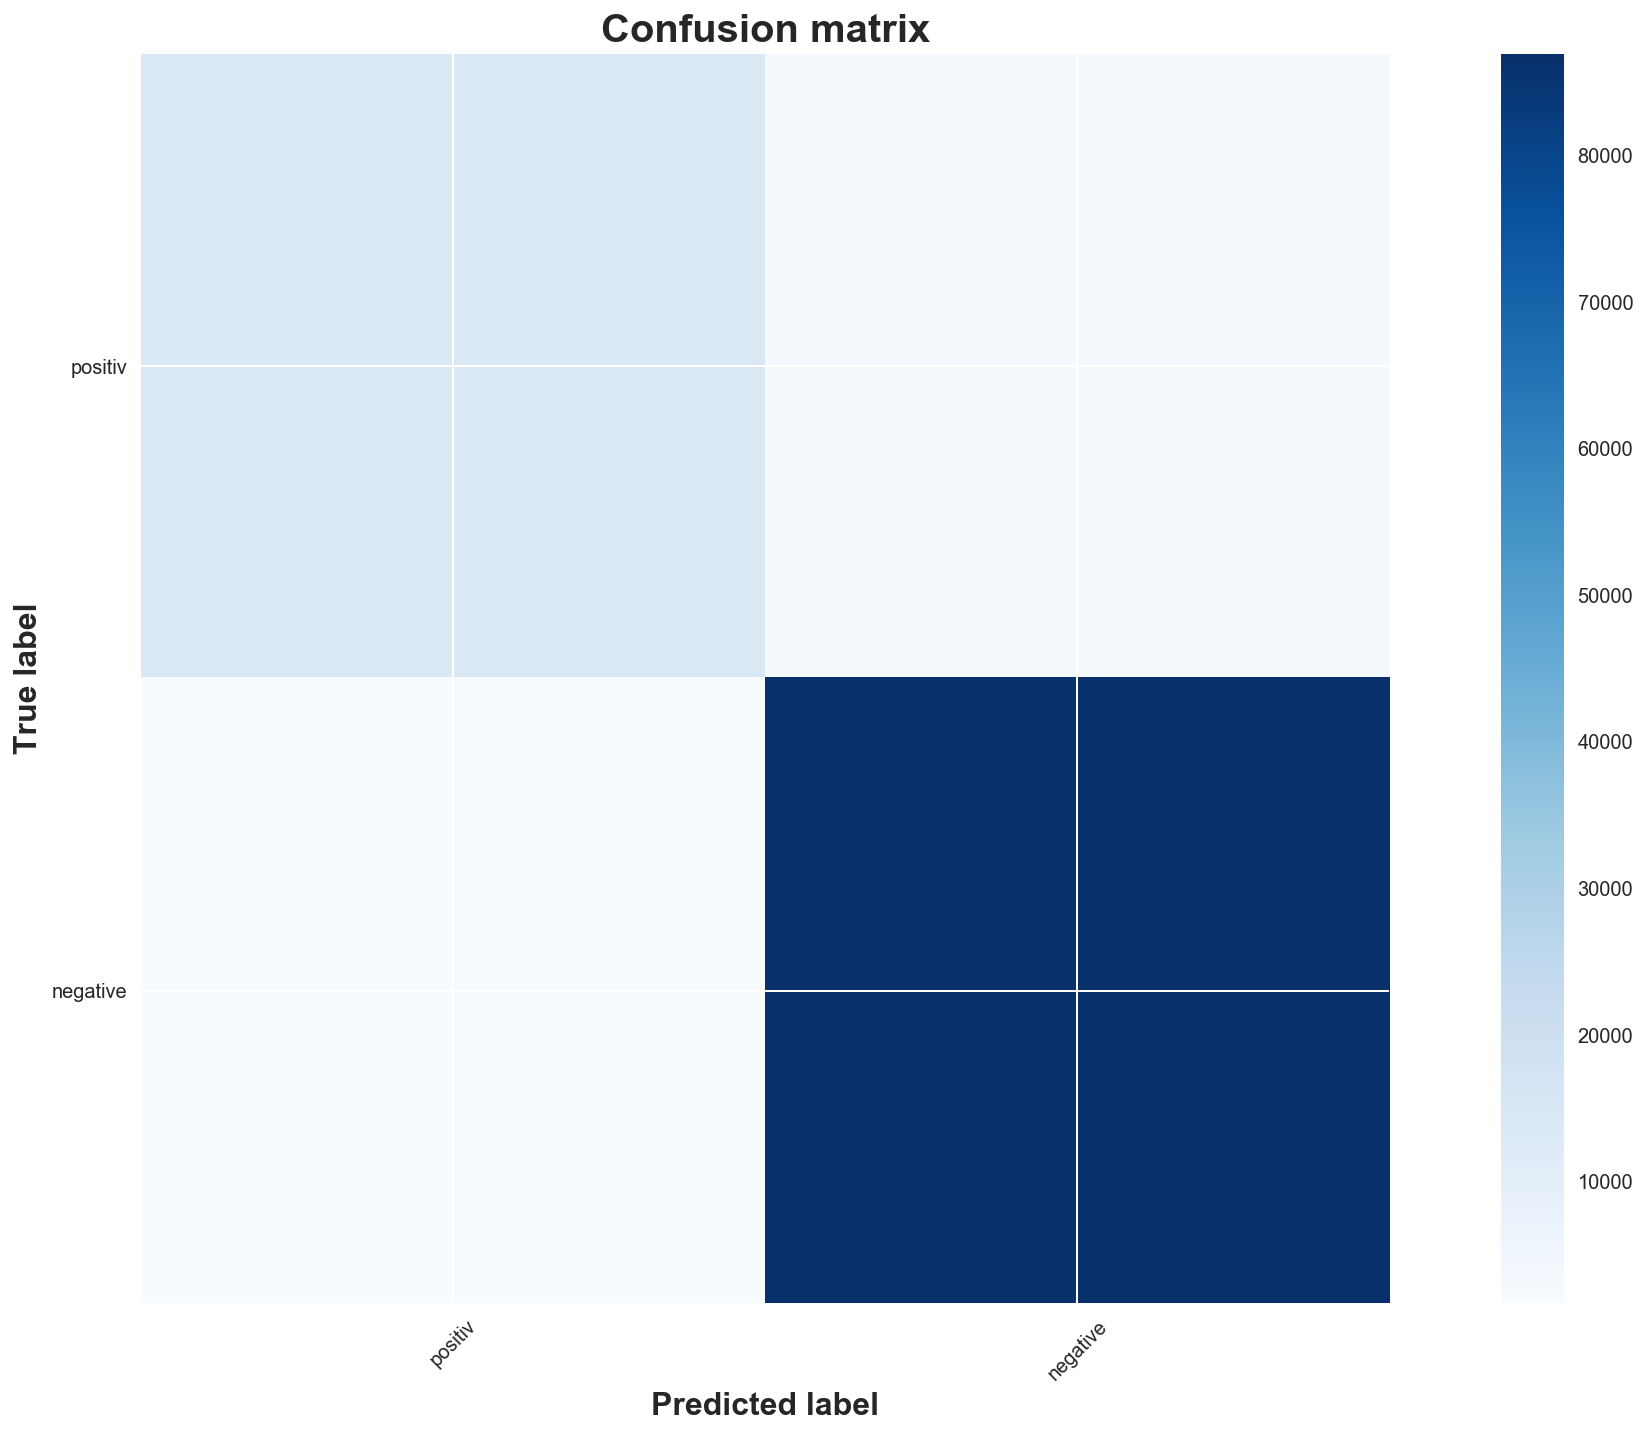

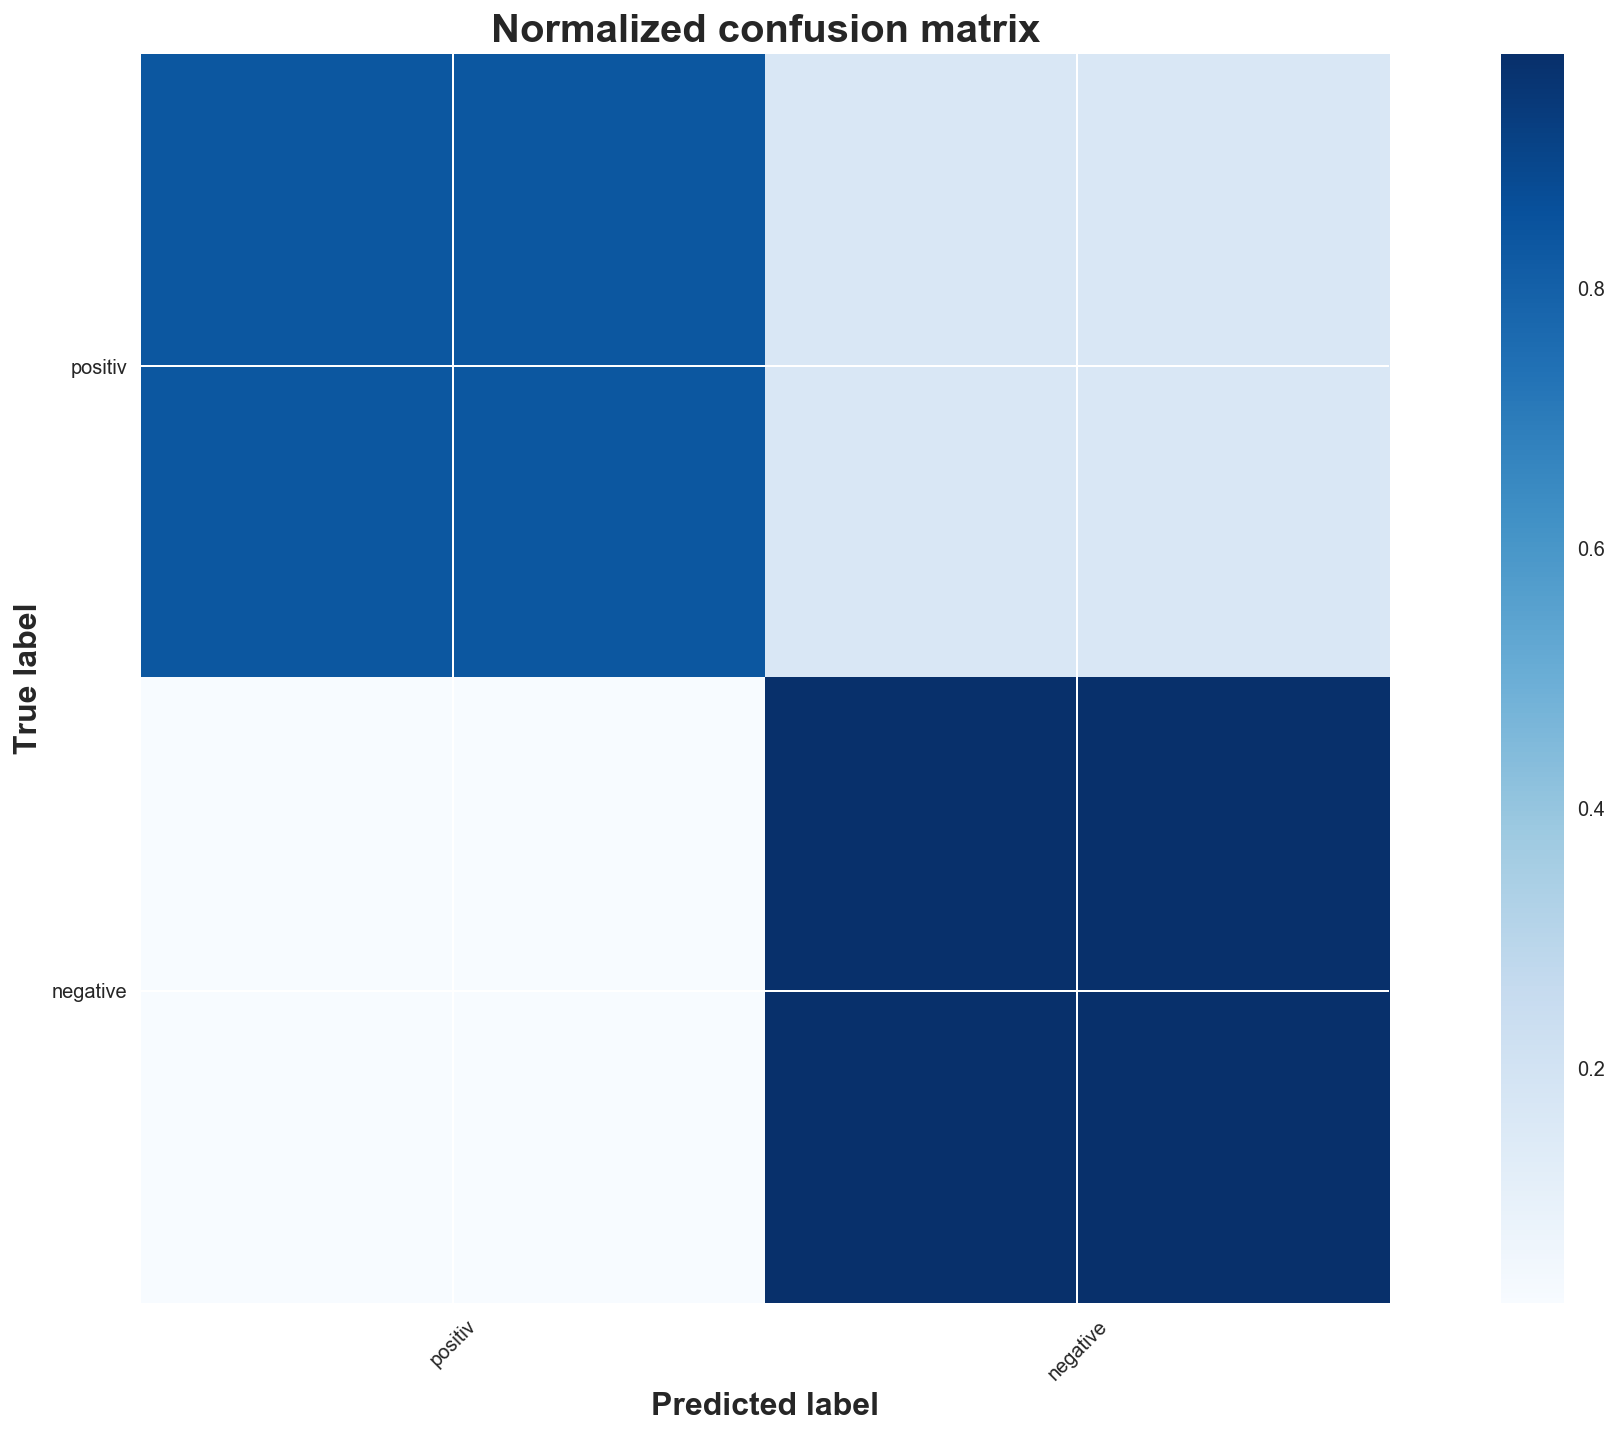

In [46]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=['positiv', 'negative']):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, pred['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

# OLD

# Data preprocessing

## Data Cleaning with NLTK

* Stemming
* Stop words removal
* Lowering
* Tokenization
* Pruning (numbers and punctuation)

In [55]:
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return ' '.join(stems)

# instantiate count vectorizer and TFIDF transformer
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()

# build new corpus from training data
intab = string.punctuation
outtab = "                                "
trantab = str.maketrans(intab, outtab)

corpus = []
for text in X_train:
    text = text.lower()
    text = text.translate(trantab)
    text = tokenize(text)
    corpus.append(text)     

X_train_counts = count_vect.fit_transform(corpus)  
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

test_set = []
for text in X_test:
    text = text.lower()
    text = text.translate(trantab)
    text=tokenize(text)
    test_set.append(text)

X_new_counts = count_vect.transform(test_set)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

df = pd.DataFrame({'Before': X_train, 'After': corpus})
print(df.head(20))

NameError: name 'X_train' is not defined

# Resources

1. https://www.kaggle.com/gpayen/building-a-prediction-model
2. https://towardsdatascience.com/text-summarization-with-amazon-reviews-41801c2210b
3. https://www.kaggle.com/eugen1701/predicting-sentiment-and-helpfulness
4. http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
